In [ ]:
!pip install keras

In [ ]:
!pip install tensorflow

With longer sequence length, different model architecture, dropout for regularization, and early stopping

In [ ]:
# Import Data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [ ]:
# Load data (csv)
path = '/content/augmento_btc_returns.xls'
df = pd.read_excel(path)
df.head()

,date,listing_close,returns,twitter_hacks,twitter_pessimistic_doubtful,twitter_banks,twitter_selling,twitter_market_manipulation,twitter_de_centralisation,twitter_angry,...,reddit_dip,reddit_launch,reddit_fomo_theme,reddit_advice_support,reddit_rebranding,reddit_wallet,reddit_good_news,reddit_problems_and_issues,reddit_mining,reddit_waiting
0,2016-11-01 01:00:00,706.00,NaN,0,0,0,1,0,0,0,...,0,1,0,13,0,0,4,1,3,3
1,2016-11-01 02:00:00,709.99,-0.005636,1,0,0,1,0,1,0,...,0,0,0,10,0,2,1,1,0,1
2,2016-11-01 03:00:00,708.54,0.002044,0,0,0,0,0,0,0,...,0,0,0,8,0,2,1,5,3,0
3,2016-11-01 04:00:00,702.85,0.008063,0,0,1,0,0,0,0,...,0,0,0,4,0,1,1,0,0,0
4,2016-11-01 05:00:00,708.50,-0.008007,0,0,0,0,0,0,0,...,0,0,0,3,0,0,1,2,0,0


               Model      Test MSE      Test MAE   Test R2
0  Linear Regression  2.354770e-32  1.194869e-16  1.000000
1   Ridge Regression  1.859995e-09  2.394004e-05  0.999996
2   Lasso Regression  5.183915e-04  1.521160e-02 -0.000500
3      Decision Tree  1.619334e-07  1.278834e-04  0.999687
4      Random Forest  9.013194e-09  4.754937e-05  0.999983


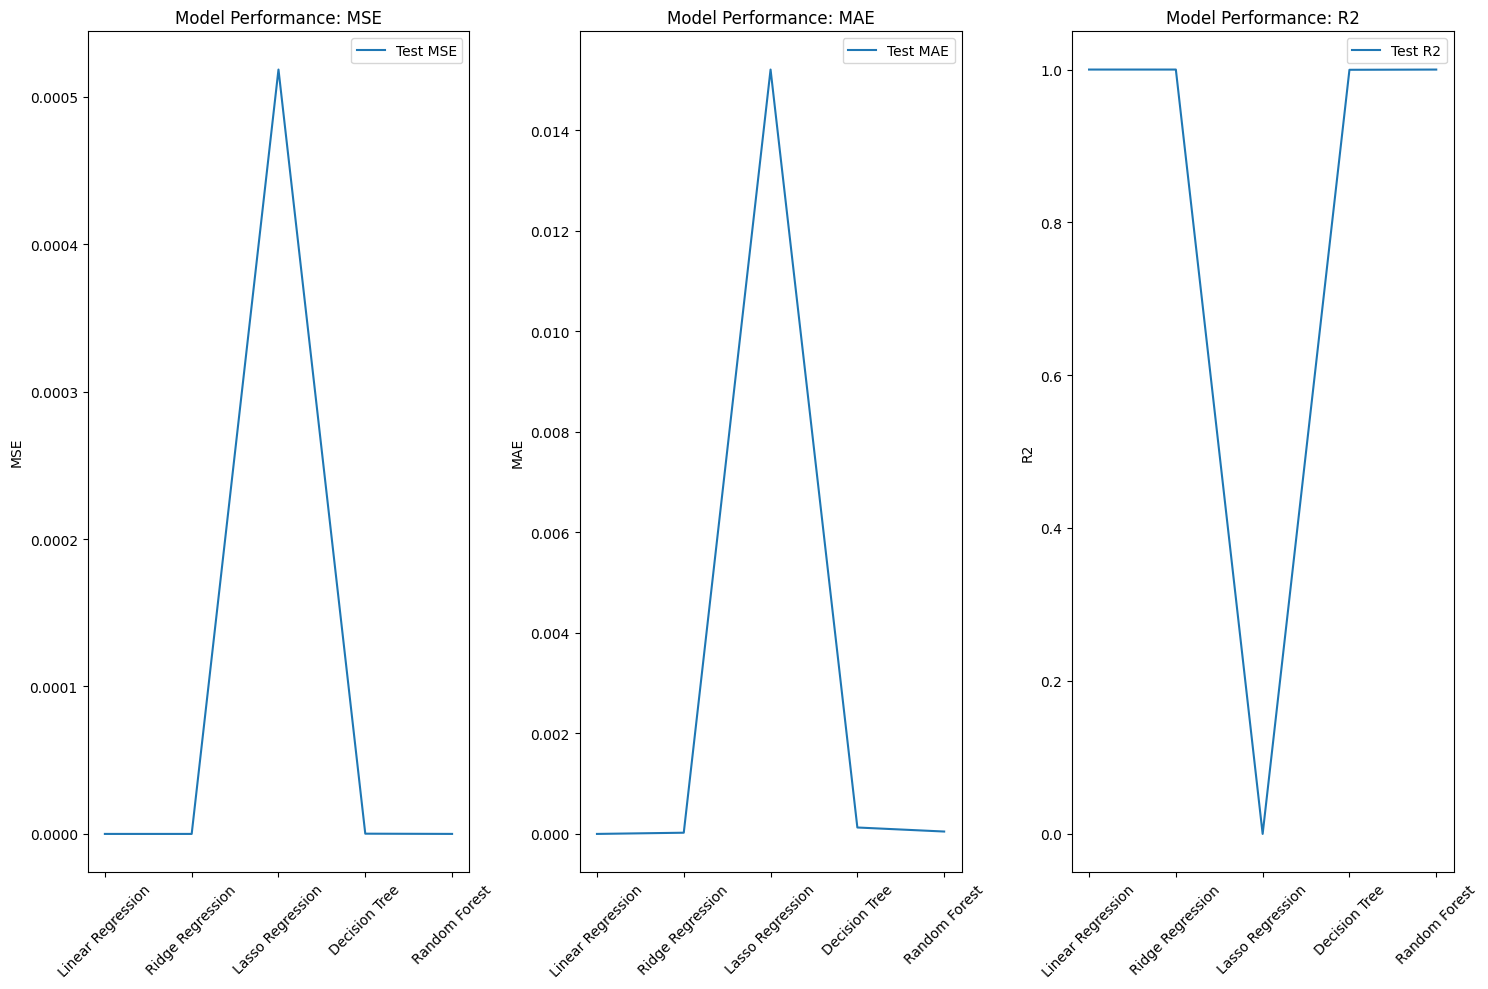

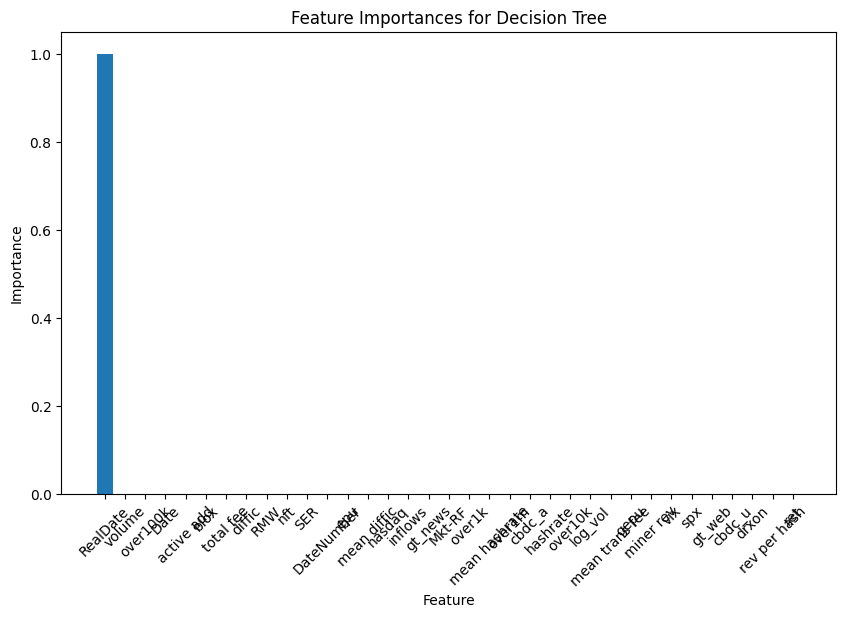

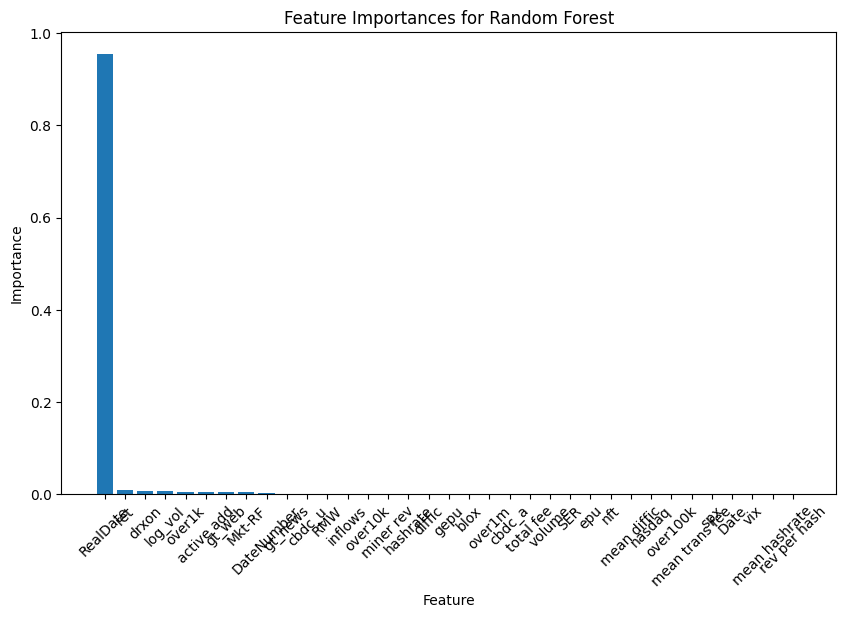

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer # Import SimpleImputer to handle NaN values
from datetime import datetime
from typing import Tuple

column_names = df.columns

# Apply the Scaling and Imputation
imputer = SimpleImputer(strategy='mean') # Create an imputer to fill NaN values with the mean
scaler = StandardScaler()
pipeline = make_pipeline(imputer, scaler) # Create a pipeline to apply imputation and scaling

X_train_scaled = pipeline.fit_transform(X_train) # Fit and transform on training data
X_test_scaled = pipeline.transform(X_test) # Transform test data using the fitted pipeline

# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor()
}


def custom_train_test_split(df: pd.DataFrame, cutoff_date: datetime, target_column_name: str) -> Tuple[pd.DataFrame, pd.Series, pd.DataFrame, pd.Series]:
    """
    Splits a DataFrame into training and testing sets based on a specified cutoff date.

    This function is designed to segment a dataset for time-series analysis, where the integrity
    of the temporal order is crucial. Data points before the cutoff date are used for training,
    while those on or after this date are reserved for testing. This method ensures that the
    testing data simulates a future period relative to the training data.

    Parameters:
    - df (pd.DataFrame): The complete dataset containing both features and the target variable.
    - cutoff_date (datetime): The date used to split the data. Data up to this date are included
      in the training set, while data from this date onwards are in the testing set.
    - target_column_name (str): The name of the target variable column in the dataset.

    Returns:
    - Tuple[pd.DataFrame, pd.Series, pd.DataFrame, pd.Series]: A tuple containing four elements:
      X_train (DataFrame), y_train (Series), X_test (DataFrame), and y_test (Series).
      X_train and X_test contain the features, while y_train and y_test contain the target variable.
    """
    df['Date'] = pd.to_datetime(df['Date'])
    train_data = df[df['Date'] < cutoff_date].reset_index(drop=True)
    test_data = df[df['Date'] >= cutoff_date].reset_index(drop=True)

    X_train = train_data[features]  # Ensure 'Date' is not in 'features'
    y_train = train_data[target_column_name]
    X_test = test_data[features]  # Ensure 'Date' is not in 'features'
    y_test = test_data[target_column_name]

    return X_train, y_train, X_test, y_test

# Define the cutoff date for splitting data
cutoff_date = datetime(2023, 1, 1)

# Split the data
X_train, y_train, X_test, y_test = custom_train_test_split(
    df=df,
    cutoff_date=cutoff_date,
    target_column_name=target
)

# Apply Imputation and Scaling in the correct order
imputer = SimpleImputer(strategy='mean') # Create an imputer to fill NaN values with the mean
scaler = StandardScaler()
pipeline = make_pipeline(imputer, scaler) # Create a pipeline to apply imputation and THEN scaling

X_train_scaled = pipeline.fit_transform(X_train) # Fit and transform on training data
X_test_scaled = pipeline.transform(X_test) # Transform test data using the fitted pipeline


results = []
feature_importances = {}

# Loop through each model, train it, evaluate, and collect results
for name, model in models.items():
    # Train the model on the training data
    model.fit(X_train_scaled, y_train)

    # Evaluate the model on the test data
    test_predictions = model.predict(X_test_scaled)
    test_mse = mean_squared_error(y_test, test_predictions)
    test_mae = mean_absolute_error(y_test, test_predictions)
    test_r2 = r2_score(y_test, test_predictions)

    # Store the performance metrics for each model
    results.append({'Model': name, 'Test MSE': test_mse, 'Test MAE': test_mae, 'Test R2': test_r2})

    # If the model has feature importances, store them for later use
    if hasattr(model, 'feature_importances_'):
        feature_importances[name] = model.feature_importances_

# Convert the results list into a DataFrame for easier viewing
results_df = pd.DataFrame(results)
print(results_df)

# Plotting performance metrics for each model
metrics = ['MSE', 'MAE', 'R2']
plt.figure(figsize=(15, 10))

for i, metric in enumerate(metrics):
    # Create a subplot for each metric
    plt.subplot(1, 3, i+1)
    plt.plot(results_df['Model'], results_df[f'Test {metric}'], label=f'Test {metric}')
    plt.title(f'Model Performance: {metric}')
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    plt.legend()

plt.tight_layout()
plt.show()

# Plotting feature importances for each model (if available)
for model_name, importances in feature_importances.items():
    # Sort the feature importances in descending order
    indices = np.argsort(importances)[::-1]
    sorted_names = [column_names[i] for i in indices]

    # Create a bar plot for each model's feature importances
    plt.figure(figsize=(10, 6))
    plt.title(f'Feature Importances for {model_name}')
    plt.bar(range(len(importances)), importances[indices], align='center')
    plt.xticks(range(len(importances)), sorted_names, rotation=45)
    plt.ylabel('Importance')
    plt.xlabel('Feature')
    plt.show()

               Model           MSE           MAE        R2
0  Linear Regression  2.354770e-32  1.194869e-16  1.000000
1   Ridge Regression  1.859995e-09  2.394004e-05  0.999996
2   Lasso Regression  5.183915e-04  1.521160e-02 -0.000500
3      Decision Tree  1.568677e-07  1.314649e-04  0.999697
4      Random Forest  6.476128e-09  4.316791e-05  0.999988
5            XGBoost  1.771149e-07  2.521485e-04  0.999658


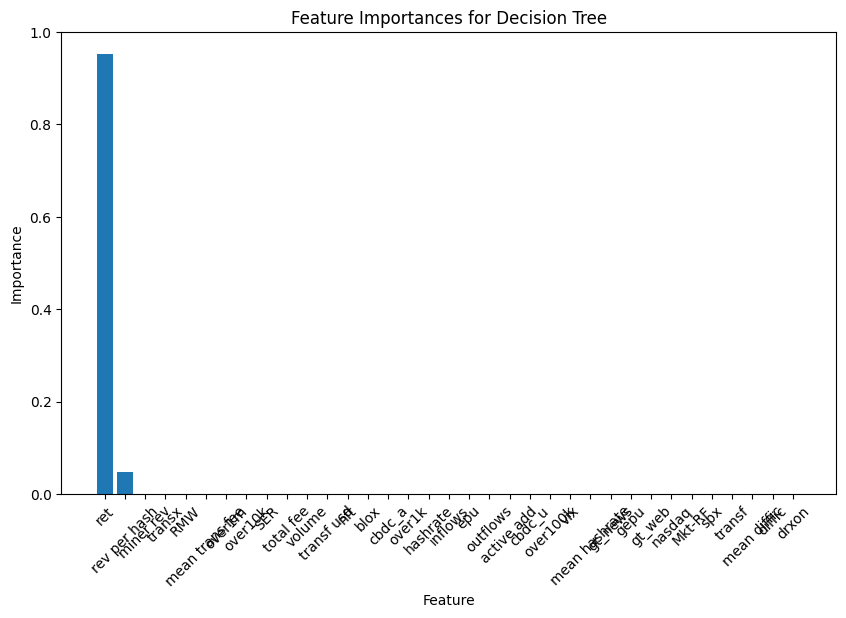

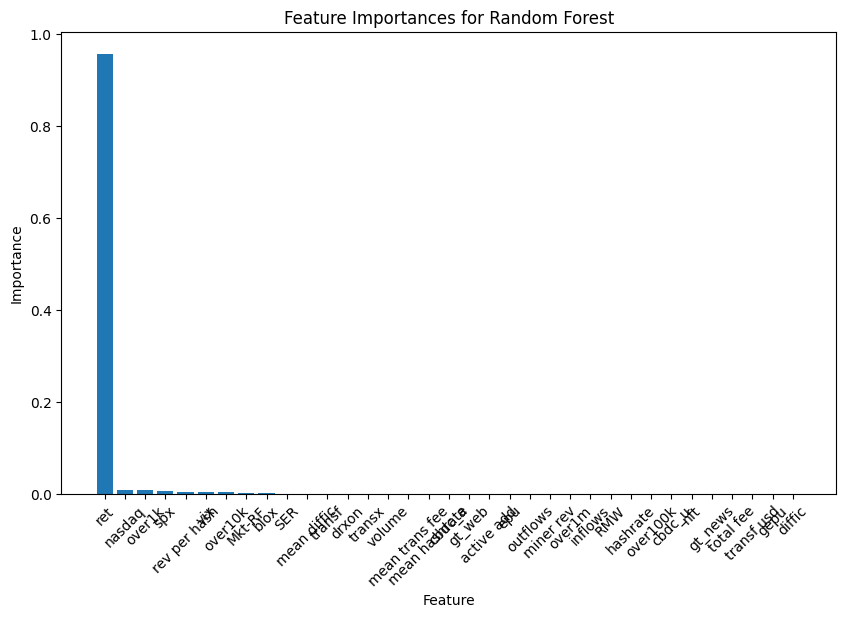

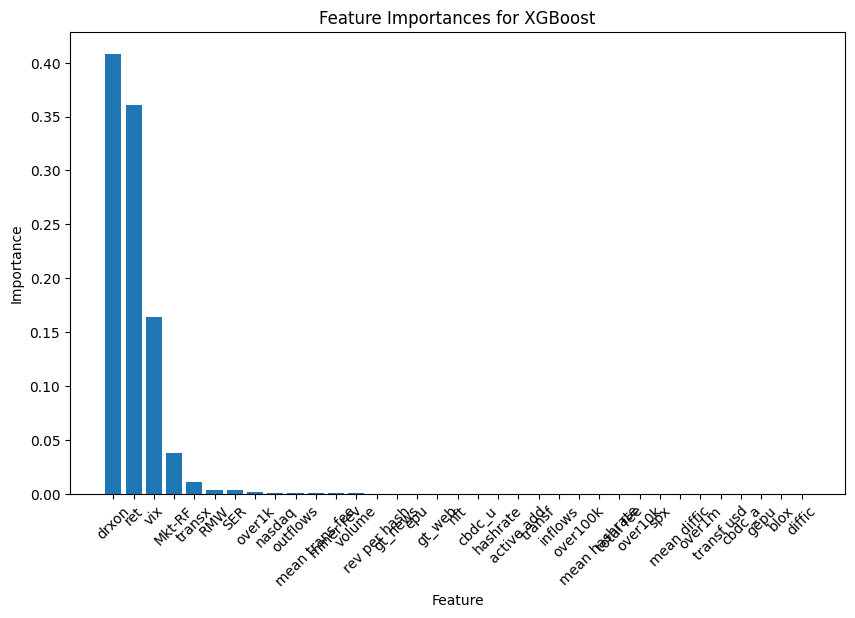

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best parameters for Random Forest: {'n_estimators': 110, 'max_depth': 10}
Best R2 score: 0.9672713186095552


In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Load data
path = '/content/btc_nov20change0F.xlsx'
df = pd.read_excel(path)
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')

# Handle missing values and convert columns to numeric
for col in df.columns:
    if col != 'Date':
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Define features and target variable
features = [
    'RMW', 'ret', 'Mkt-RF', 'volume', 'drxon', 'spx', 'nasdaq', 'vix',
    'epu', 'gepu', 'nft', 'cbdc_u', 'cbdc_a', 'gt_web', 'gt_news',
    'SER', 'active add', 'over10k', 'over100k', 'over1m', 'over1k',
    'mean trans fee', 'total fee', 'miner rev', 'rev per hash', 'hashrate',
    'mean hashrate', 'blox', 'diffic', 'mean diffic', 'inflows', 'outflows',
    'transx', 'transf usd', 'transf'
]
target = 'ret'

# Split the data
cutoff_date = pd.to_datetime('2023-01-01')
train_data = df[df['Date'] < cutoff_date].reset_index(drop=True)
test_data = df[df['Date'] >= cutoff_date].reset_index(drop=True)

X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]

# Preprocess data using a pipeline
pipeline = make_pipeline(SimpleImputer(strategy='mean'), StandardScaler())
X_train_scaled = pipeline.fit_transform(X_train)
X_test_scaled = pipeline.transform(X_test)

# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'XGBoost': XGBRegressor()
}

# Train and evaluate models
results = []
feature_importances = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    predictions = model.predict(X_test_scaled)

    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    results.append({'Model': name, 'MSE': mse, 'MAE': mae, 'R2': r2})

    if hasattr(model, 'feature_importances_'):
        feature_importances[name] = model.feature_importances_

results_df = pd.DataFrame(results)
print(results_df)

# Plot feature importances
for name, importances in feature_importances.items():
    indices = np.argsort(importances)[::-1]
    sorted_names = [features[i] for i in indices]

    plt.figure(figsize=(10, 6))
    plt.title(f'Feature Importances for {name}')
    plt.bar(range(len(importances)), importances[indices], align='center')
    plt.xticks(range(len(importances)), sorted_names, rotation=45)
    plt.ylabel('Importance')
    plt.xlabel('Feature')
    plt.show()

# Hyperparameter tuning (example for Random Forest)
param_grid = {
    'n_estimators': range(10, 210, 10),
    'max_depth': range(3, 11)
}
rf = RandomForestRegressor()
grid_search = RandomizedSearchCV(rf, param_grid, n_iter=50, scoring='r2', cv=5, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

print(f"Best parameters for Random Forest: {grid_search.best_params_}")
print(f"Best R2 score: {grid_search.best_score_}")


Possible 2

               Model  Test MSE  Test MAE   Test R2
0  Linear Regression  0.000133  0.006452  0.743912
1   Ridge Regression  0.000131  0.006349  0.747499
2   Lasso Regression  0.000518  0.015212 -0.000500
3      Decision Tree  0.000036  0.003849  0.931340
4      Random Forest  0.000008  0.002011  0.983689


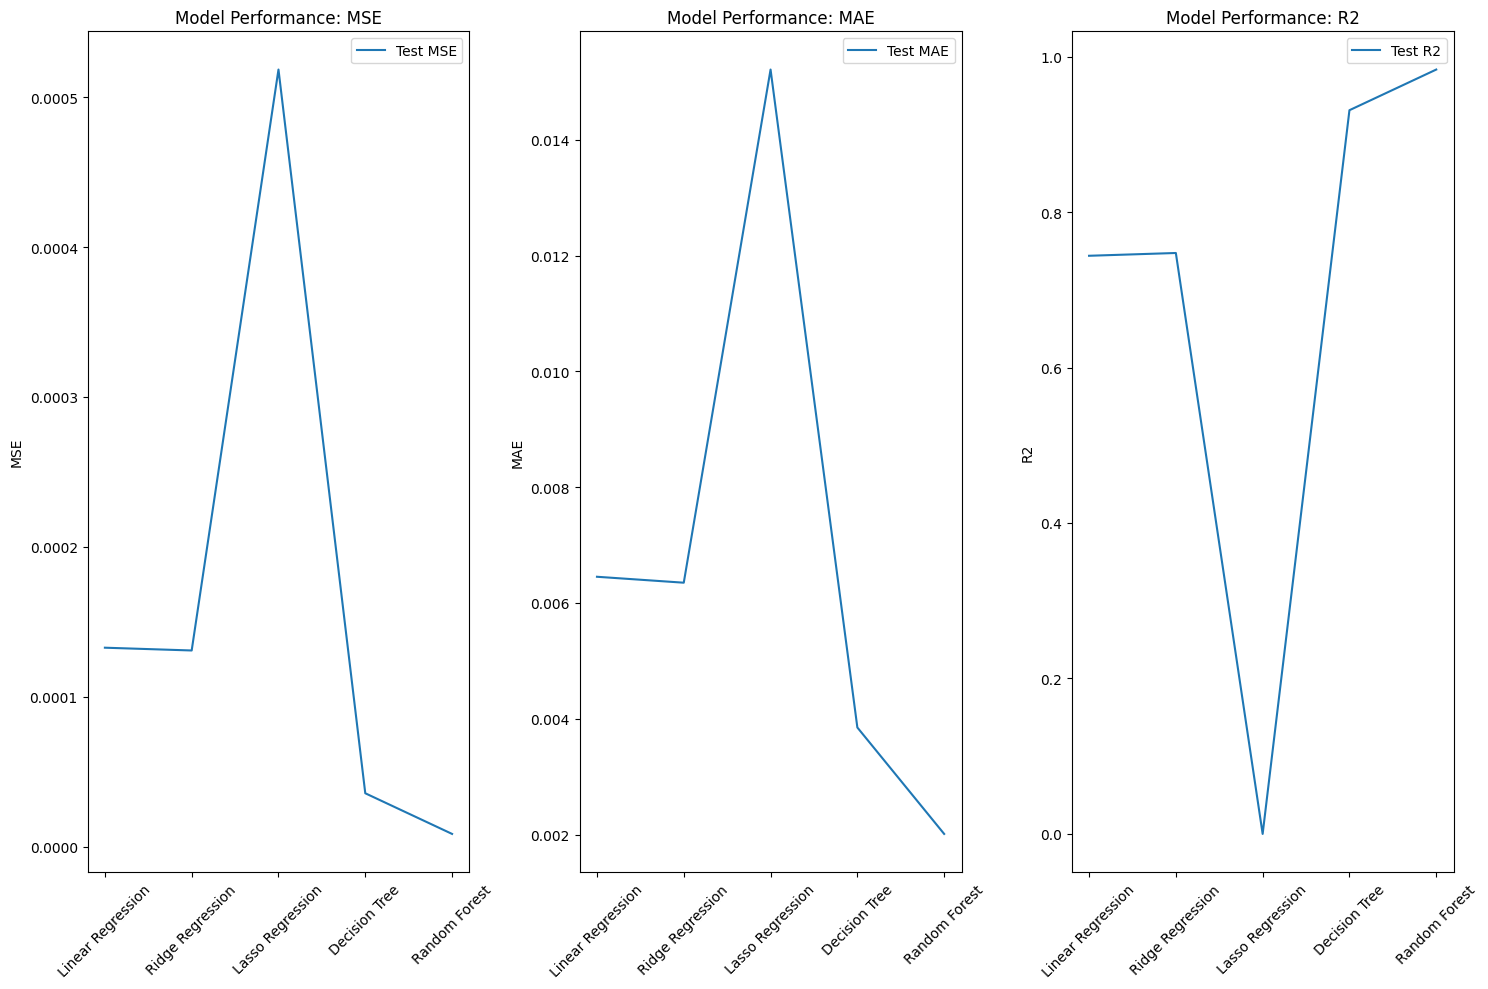

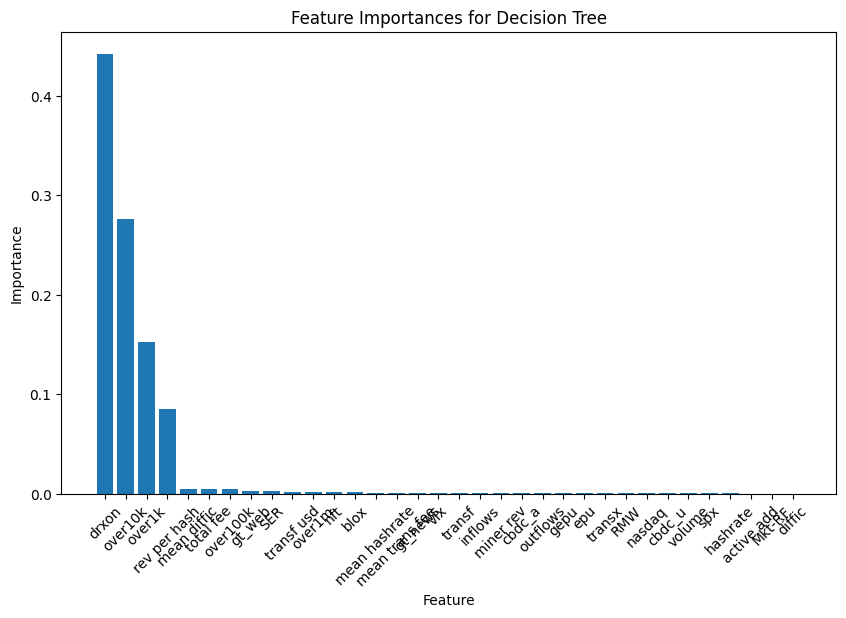

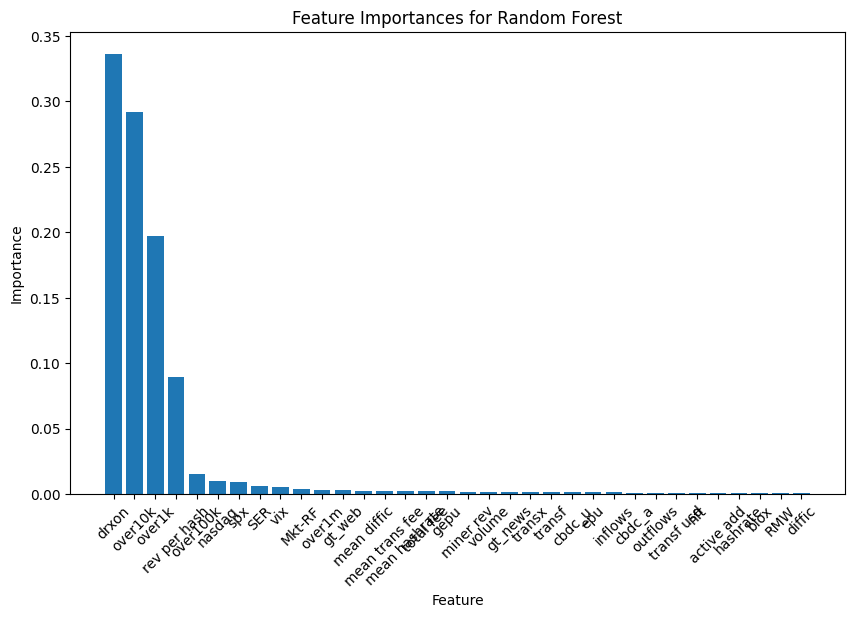

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
from datetime import datetime
from typing import Tuple

# Load data (replace with your actual file path)
path = '/content/btc_nov20change0F.xlsx'
df = pd.read_excel(path)
df['Date'] = pd.to_datetime(df['Date'])

# Features and target variable
features = ['RMW', 'Mkt-RF', 'volume', 'drxon', 'spx', 'nasdaq', 'vix', 'epu', 'gepu',
            'nft', 'cbdc_u', 'cbdc_a', 'gt_web', 'gt_news', 'SER', 'active add',
            'over10k', 'over100k', 'over1m', 'over1k', 'mean trans fee', 'total fee',
            'miner rev', 'rev per hash', 'hashrate', 'mean hashrate', 'blox', 'diffic',
            'mean diffic', 'inflows', 'outflows', 'transx', 'transf usd', 'transf']
target = 'ret'

# Convert features to numeric, coercing errors to NaN
df[features] = df[features].apply(pd.to_numeric, errors='coerce')

# Define the cutoff date for splitting data
cutoff_date = datetime(2023, 1, 1)

# Function to split the data into training and testing sets
def custom_train_test_split(df: pd.DataFrame, cutoff_date: datetime, target_column_name: str) -> Tuple[pd.DataFrame, pd.Series, pd.DataFrame, pd.Series]:
    train_data = df[df['Date'] < cutoff_date].reset_index(drop=True)
    test_data = df[df['Date'] >= cutoff_date].reset_index(drop=True)

    X_train = train_data[features]
    y_train = train_data[target_column_name]
    X_test = test_data[features]
    y_test = test_data[target_column_name]

    return X_train, y_train, X_test, y_test

# Split the data
X_train, y_train, X_test, y_test = custom_train_test_split(df, cutoff_date, target)

# Apply Imputation and Scaling in the correct order
imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()
pipeline = make_pipeline(imputer, scaler)

X_train_scaled = pipeline.fit_transform(X_train)
X_test_scaled = pipeline.transform(X_test)

# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor()
}

results = []
feature_importances = {}

# Loop through each model, train it, evaluate, and collect results
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    test_predictions = model.predict(X_test_scaled)
    test_mse = mean_squared_error(y_test, test_predictions)
    test_mae = mean_absolute_error(y_test, test_predictions)
    test_r2 = r2_score(y_test, test_predictions)

    results.append({'Model': name, 'Test MSE': test_mse, 'Test MAE': test_mae, 'Test R2': test_r2})

    if hasattr(model, 'feature_importances_'):
        feature_importances[name] = model.feature_importances_

# Convert the results list into a DataFrame for easier viewing
results_df = pd.DataFrame(results)
print(results_df)

# Plotting performance metrics for each model
metrics = ['MSE', 'MAE', 'R2']
plt.figure(figsize=(15, 10))

for i, metric in enumerate(metrics):
    plt.subplot(1, 3, i+1)
    plt.plot(results_df['Model'], results_df[f'Test {metric}'], label=f'Test {metric}')
    plt.title(f'Model Performance: {metric}')
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    plt.legend()

plt.tight_layout()
plt.show()

# Plotting feature importances for each model (if available)
for model_name, importances in feature_importances.items():
    indices = np.argsort(importances)[::-1]
    sorted_names = [features[i] for i in indices]

    plt.figure(figsize=(10, 6))
    plt.title(f'Feature Importances for {model_name}')
    plt.bar(range(len(importances)), importances[indices], align='center')
    plt.xticks(range(len(importances)), sorted_names, rotation=45)
    plt.ylabel('Importance')
    plt.xlabel('Feature')
    plt.show()


New Dataset

Posible

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Load data (replace with your actual file path)
path = '/content/augmento_btc_returns.xls'
df = pd.read_excel(path)

# Check if 'Date' column exists, if not, try finding a similar column
if 'Date' not in df.columns:
    # Try to find a column that looks like a date column
    date_columns = [col for col in df.columns if 'date' in col.lower()]
    if date_columns:
        date_column = date_columns[0]  # Use the first date-like column found
        print(f"Using column '{date_column}' as date column.")
        df[date_column] = pd.to_datetime(df[date_column])
    else:
        print("No date column found. Please check your data.")
else:
    df['Date'] = pd.to_datetime(df['Date'])  # Convert 'Date' column to datetime

# Define your features
features = [
    'twitter_hacks', 'twitter_pessimistic_doubtful', 'twitter_banks', 'twitter_selling', 'twitter_market_manipulation',
    'twitter_de_centralisation', 'twitter_angry', 'twitter_etf', 'twitter_leverage', 'twitter_bottom',
    'twitter_institutional_money', 'twitter_fomo', 'twitter_prediction', 'twitter_adoption', 'twitter_fearful_concerned',
    'twitter_portfolio', 'twitter_fud_theme', 'twitter_whitepaper', 'twitter_announcements', 'twitter_technical_analysis',
    'twitter_flippening', 'twitter_community', 'twitter_investing_trading', 'twitter_euphoric_excited', 'twitter_hodling',
    'twitter_ico', 'twitter_bearish', 'twitter_going_short', 'twitter_uncertain', 'twitter_volume', 'twitter_risk',
    'twitter_governance', 'twitter_ban', 'twitter_cheap', 'twitter_short_term_trading', 'twitter_fork', 'twitter_progress',
    'twitter_shilling', 'twitter_bullish', 'twitter_happy', 'twitter_bubble', 'twitter_bots', 'twitter_hopeful',
    'twitter_bug', 'twitter_open_source', 'twitter_token_economics', 'twitter_security', 'twitter_marketing',
    'twitter_bad_news', 'twitter_due_diligence', 'twitter_team', 'twitter_partnerships', 'twitter_pump_and_dump',
    'twitter_sad', 'twitter_panicking', 'twitter_listing', 'twitter_regulation_politics', 'twitter_dip', 'twitter_launch',
    'twitter_fomo_theme', 'twitter_advice_support', 'twitter_rebranding', 'twitter_wallet', 'twitter_good_news',
    'twitter_problems_and_issues', 'twitter_mining', 'twitter_waiting', 'twitter_learning', 'twitter_scaling', 'twitter_fees',
    'twitter_roadmap', 'twitter_recovery', 'twitter_technology', 'twitter_mistrustful', 'twitter_marketcap', 'twitter_positive',
    'twitter_tax', 'twitter_long_term_investing', 'twitter_strategy', 'twitter_competition', 'twitter_whales',
    'twitter_correction', 'twitter_stablecoin', 'twitter_buying', 'twitter_warning', 'twitter_annoyed_frustrated',
    'twitter_price', 'twitter_use_case_applications', 'twitter_rumor', 'twitter_scam_fraud', 'twitter_airdrop',
    'twitter_optimistic', 'twitter_negative', 'bitcointalk_hacks', 'bitcointalk_pessimistic_doubtful', 'bitcointalk_banks',
    'bitcointalk_selling', 'bitcointalk_market_manipulation', 'bitcointalk_de_centralisation', 'bitcointalk_angry',
    'bitcointalk_etf', 'bitcointalk_leverage', 'bitcointalk_bottom', 'bitcointalk_institutional_money', 'bitcointalk_fomo',
    'bitcointalk_prediction', 'bitcointalk_adoption', 'bitcointalk_fearful_concerned', 'bitcointalk_portfolio',
    'bitcointalk_fud_theme', 'bitcointalk_whitepaper', 'bitcointalk_announcements', 'bitcointalk_technical_analysis',
    'bitcointalk_flippening', 'bitcointalk_community', 'bitcointalk_investing_trading', 'bitcointalk_euphoric_excited',
    'bitcointalk_hodling', 'bitcointalk_ico', 'bitcointalk_bearish', 'bitcointalk_going_short', 'bitcointalk_uncertain',
    'bitcointalk_volume', 'bitcointalk_risk', 'bitcointalk_governance', 'bitcointalk_ban', 'bitcointalk_cheap',
    'bitcointalk_short_term_trading', 'bitcointalk_fork', 'bitcointalk_progress', 'bitcointalk_shilling', 'bitcointalk_bullish',
    'bitcointalk_happy', 'bitcointalk_bubble', 'bitcointalk_bots', 'bitcointalk_hopeful', 'bitcointalk_bug',
    'bitcointalk_open_source', 'bitcointalk_token_economics', 'bitcointalk_security', 'bitcointalk_marketing',
    'bitcointalk_bad_news', 'bitcointalk_due_diligence', 'bitcointalk_team', 'bitcointalk_partnerships', 'bitcointalk_pump_and_dump',
    'bitcointalk_sad', 'bitcointalk_panicking', 'bitcointalk_listing', 'bitcointalk_regulation_politics', 'bitcointalk_dip',
    'bitcointalk_launch', 'bitcointalk_fomo_theme', 'bitcointalk_advice_support', 'bitcointalk_rebranding', 'bitcointalk_wallet',
    'bitcointalk_good_news', 'bitcointalk_problems_and_issues', 'bitcointalk_mining', 'bitcointalk_waiting', 'bitcointalk_learning',
    'bitcointalk_scaling', 'bitcointalk_fees', 'bitcointalk_roadmap', 'bitcointalk_recovery', 'bitcointalk_technology',
    'bitcointalk_mistrustful', 'bitcointalk_marketcap', 'bitcointalk_positive', 'bitcointalk_tax', 'bitcointalk_long_term_investing',
    'bitcointalk_strategy', 'bitcointalk_competition', 'bitcointalk_whales', 'bitcointalk_correction', 'bitcointalk_stablecoin',
    'bitcointalk_buying', 'bitcointalk_warning', 'bitcointalk_annoyed_frustrated', 'bitcointalk_price', 'bitcointalk_use_case_applications',
    'bitcointalk_rumor', 'bitcointalk_scam_fraud', 'bitcointalk_airdrop', 'bitcointalk_optimistic', 'bitcointalk_negative',
    'reddit_hacks', 'reddit_pessimistic_doubtful', 'reddit_banks', 'reddit_selling', 'reddit_market_manipulation',
    'reddit_de_centralisation', 'reddit_angry', 'reddit_etf', 'reddit_leverage', 'reddit_bottom', 'reddit_institutional_money',
    'reddit_fomo', 'reddit_prediction', 'reddit_adoption', 'reddit_fearful_concerned', 'reddit_portfolio', 'reddit_fud_theme',
    'reddit_whitepaper', 'reddit_announcements', 'reddit_technical_analysis', 'reddit_flippening', 'reddit_community',
    'reddit_investing_trading', 'reddit_euphoric_excited', 'reddit_hodling', 'reddit_ico', 'reddit_bearish', 'reddit_going_short',
    'reddit_uncertain', 'reddit_volume', 'reddit_risk', 'reddit_governance', 'reddit_ban', 'reddit_cheap', 'reddit_short_term_trading',
    'reddit_fork', 'reddit_progress', 'reddit_shilling', 'reddit_bullish', 'reddit_happy', 'reddit_bubble', 'reddit_bots',
    'reddit_hopeful', 'reddit_bug', 'reddit_open_source', 'reddit_token_economics', 'reddit_security', 'reddit_marketing',
    'reddit_bad_news', 'reddit_due_diligence', 'reddit_team', 'reddit_partnerships', 'reddit_pump_and_dump', 'reddit_sad',
    'reddit_panicking', 'reddit_listing', 'reddit_regulation_politics', 'reddit_dip', 'reddit_launch', 'reddit_fomo_theme',
    'reddit_advice_support', 'reddit_rebranding', 'reddit_wallet', 'reddit_good_news', 'reddit_problems_and_issues', 'reddit_mining',
    'reddit_waiting', 'reddit_learning', 'reddit_scaling', 'reddit_fees', 'reddit_roadmap', 'reddit_recovery', 'reddit_technology',
    'reddit_mistrustful', 'reddit_marketcap', 'reddit_positive', 'reddit_tax', 'reddit_long_term_investing', 'reddit_strategy',
    'reddit_competition', 'reddit_whales', 'reddit_correction', 'reddit_stablecoin', 'reddit_buying', 'reddit_warning',
    'reddit_annoyed_frustrated', 'reddit_price', 'reddit_use_case_applications', 'reddit_rumor', 'reddit_scam_fraud', 'reddit_airdrop',
    'reddit_optimistic', 'reddit_negative'
]

target = 'returns'


Using column 'date' as date column.


In [ ]:
# Check if all features are present in the DataFrame
missing_features = [f for f in features if f not in df.columns]
if missing_features:
    print(f"Warning: The following features are not in the DataFrame: {missing_features}")

# Option 1: Remove missing features
features = [f for f in features if f in df.columns]

# Now you can safely select the features
X = df[features]
y = df[target]

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # Adjust test_size and random_state as needed

# Handle missing values in the target variable
imputer = SimpleImputer(strategy='mean')  # Or another strategy like 'median'
# Convert Pandas Series to NumPy arrays before reshaping
y_train_reshaped = imputer.fit_transform(y_train.values.reshape(-1, 1))
y_test_reshaped = imputer.transform(y_test.values.reshape(-1, 1))

Mean Squared Error: 6.839789890177169e-05
               Model  Test MSE  Test MAE   Test R2
0  Linear Regression  0.000068  0.004931  0.038609
1   Ridge Regression  0.000068  0.004931  0.038609
2   Lasso Regression  0.000071  0.004897 -0.000011
3      Decision Tree  0.000134  0.007301 -0.886320
4      Random Forest  0.000069  0.004860  0.033630


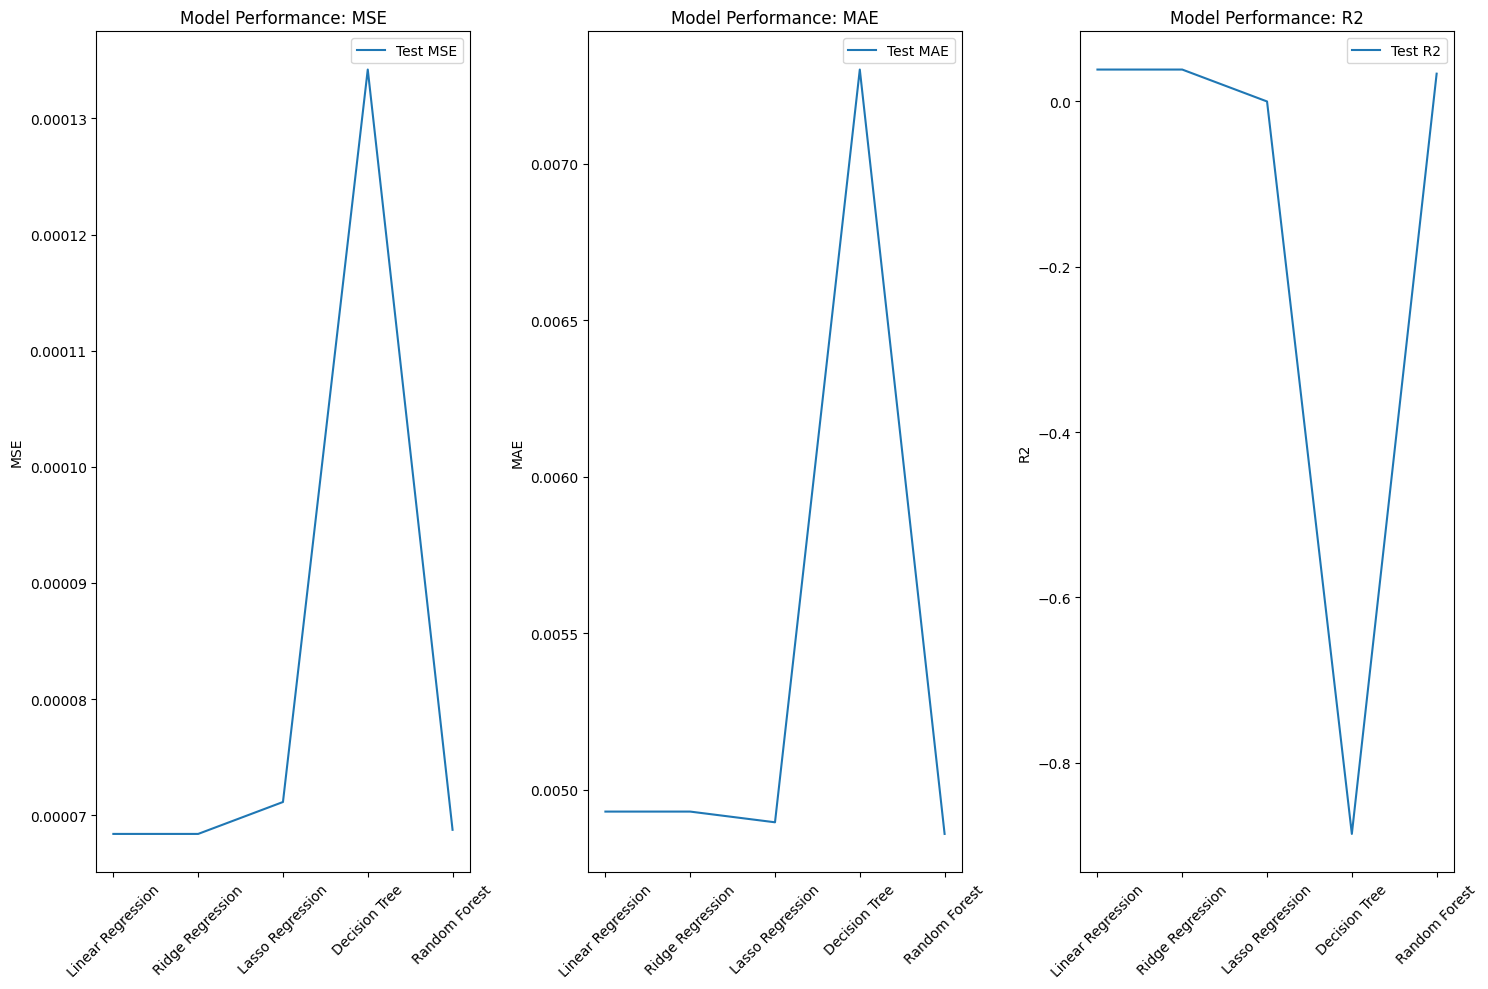

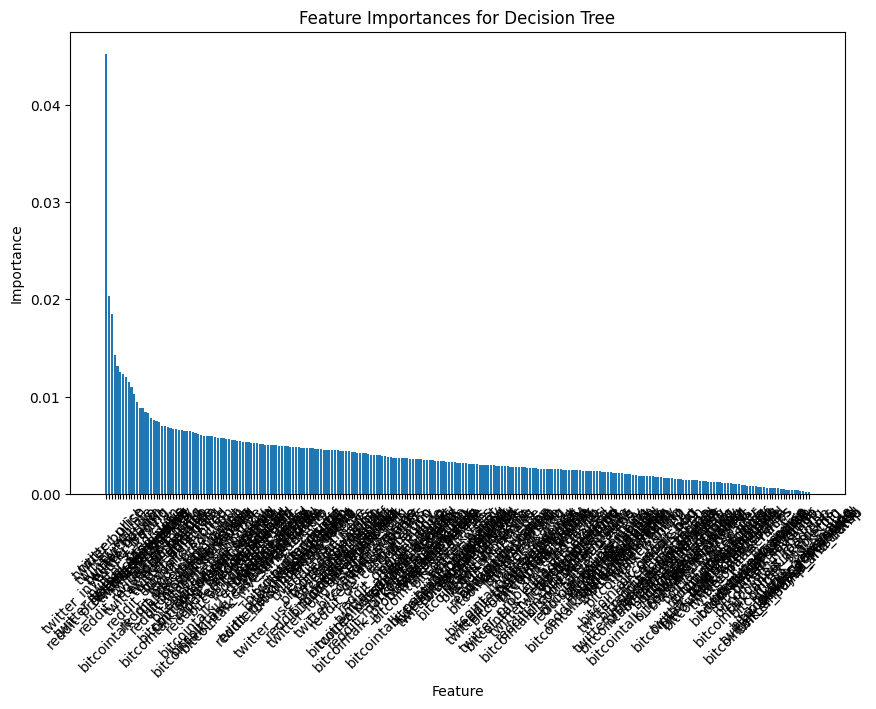

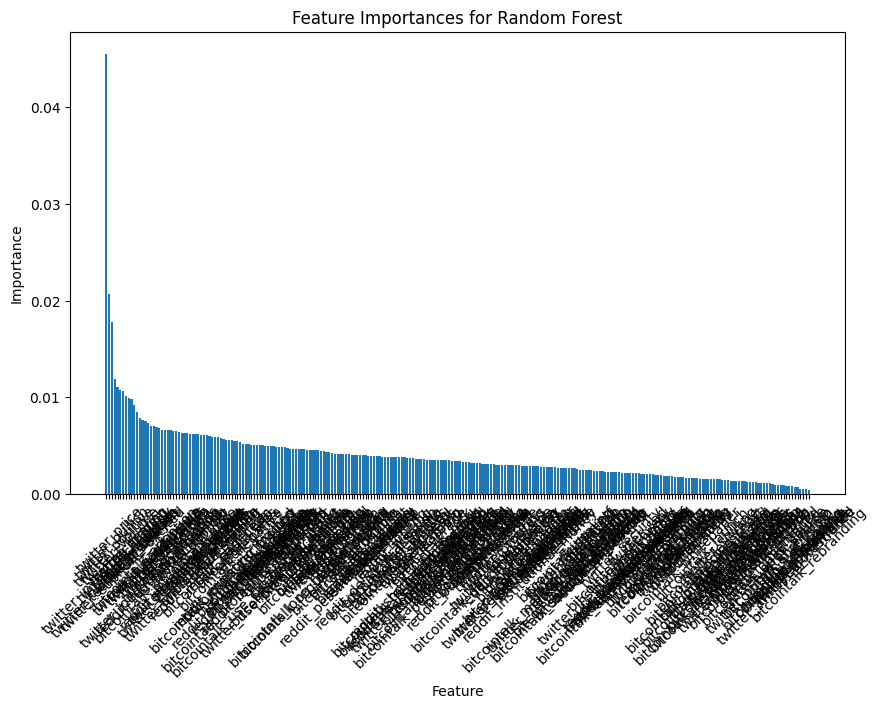

In [ ]:
# Assume df is your DataFrame containing all the data
# Replace 'returns' with the actual name of your target column
target = 'returns'

# Split the data into features and target
X = df[features]
y = df[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Handle missing values and scale the data
imputer = SimpleImputer(strategy='mean') # Impute missing values in features
scaler = StandardScaler()

pipeline = make_pipeline(imputer, scaler)

X_train_scaled = pipeline.fit_transform(X_train)
X_test_scaled = pipeline.transform(X_test)

# Handle missing values in the target variable (y_train and y_test)
y_train = imputer.fit_transform(y_train.values.reshape(-1, 1)).ravel() # Impute and flatten
y_test = imputer.transform(y_test.values.reshape(-1, 1)).ravel() # Impute and flatten

# Train a linear regression model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Make predictions and evaluate the model
y_pred = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor()
}

results = []
feature_importances = {}

# Loop through each model, train it, evaluate, and collect results
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    test_predictions = model.predict(X_test_scaled)
    test_mse = mean_squared_error(y_test, test_predictions)
    test_mae = mean_absolute_error(y_test, test_predictions)
    test_r2 = r2_score(y_test, test_predictions)

    results.append({'Model': name, 'Test MSE': test_mse, 'Test MAE': test_mae, 'Test R2': test_r2})

    if hasattr(model, 'feature_importances_'):
        feature_importances[name] = model.feature_importances_

# Convert the results list into a DataFrame for easier viewing
results_df = pd.DataFrame(results)
print(results_df)

# Plotting performance metrics for each model
metrics = ['MSE', 'MAE', 'R2']
plt.figure(figsize=(15, 10))

for i, metric in enumerate(metrics):
    plt.subplot(1, 3, i+1)
    plt.plot(results_df['Model'], results_df[f'Test {metric}'], label=f'Test {metric}')
    plt.title(f'Model Performance: {metric}')
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    plt.legend()

plt.tight_layout()
plt.show()

# Plotting feature importances for each model (if available)
for model_name, importances in feature_importances.items():
    indices = np.argsort(importances)[::-1]
    sorted_names = [features[i] for i in indices]

    plt.figure(figsize=(10, 6))
    plt.title(f'Feature Importances for {model_name}')
    plt.bar(range(len(importances)), importances[indices], align='center')
    plt.xticks(range(len(importances)), sorted_names, rotation=45)
    plt.ylabel('Importance')
    plt.xlabel('Feature')
    plt.show()


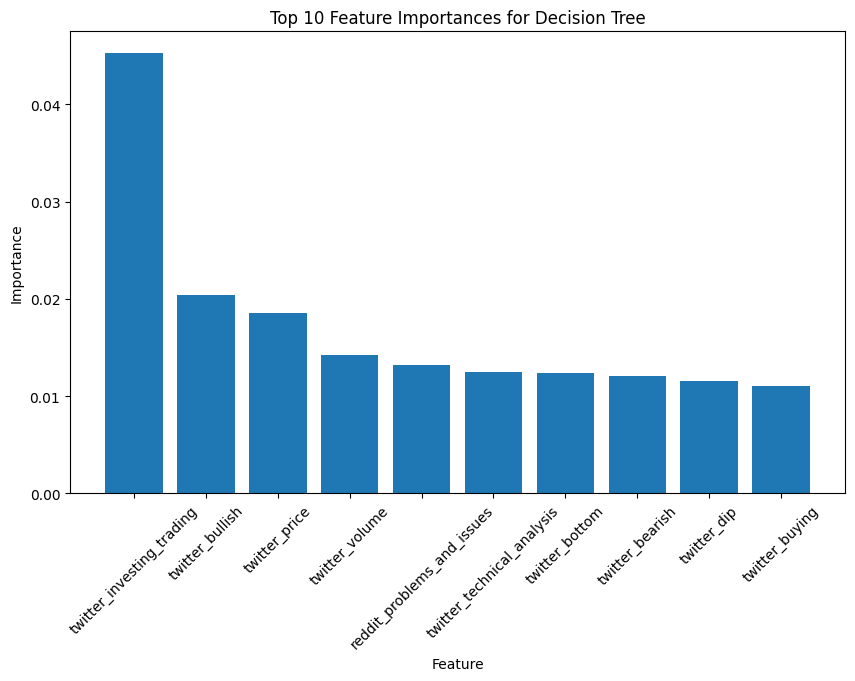

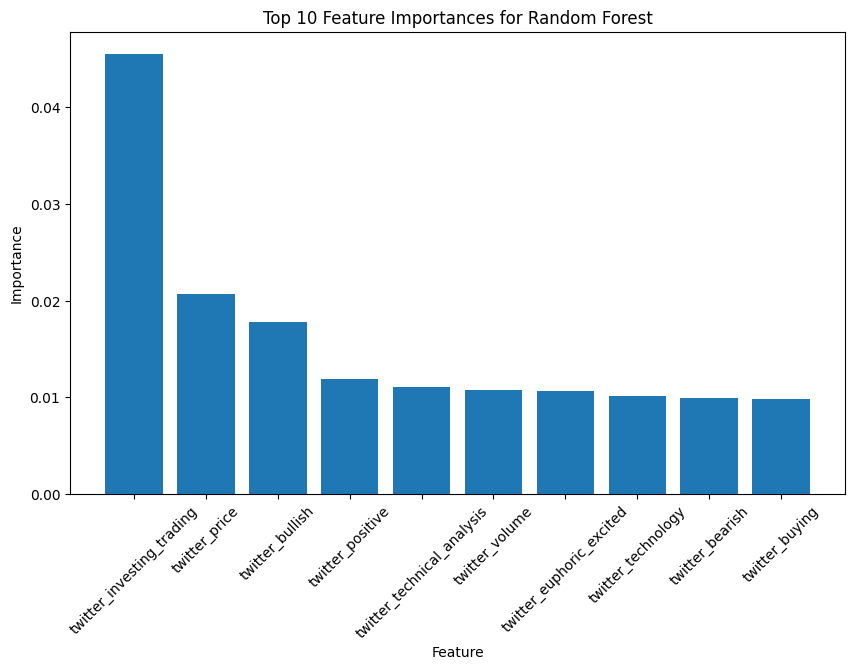

In [ ]:
# Plotting feature importances for each model (if available)
for model_name, importances in feature_importances.items():
  # Sort features by importance in descending order
  indices = np.argsort(importances)[::-1]
  sorted_names = [features[i] for i in indices]

  # Truncate to top 10 features
  top_10_features = sorted_names[:10]
  top_10_importances = importances[indices][:10]

  plt.figure(figsize=(10, 6))
  plt.title(f'Top 10 Feature Importances for {model_name}')
  plt.bar(range(len(top_10_importances)), top_10_importances, align='center')
  plt.xticks(range(len(top_10_importances)), top_10_features, rotation=45)
  plt.ylabel('Importance')
  plt.xlabel('Feature')
  plt.show()

Experiment 2 - Split the training and testing across years, with scaling

               Model  Test MSE  Test MAE   Test R2
0  Linear Regression  0.000025  0.003090  0.004799
1   Ridge Regression  0.000025  0.003090  0.004804
2   Lasso Regression  0.000025  0.003017 -0.000156
3      Decision Tree  0.000058  0.004886 -1.358150
4      Random Forest  0.000025  0.003069 -0.011251


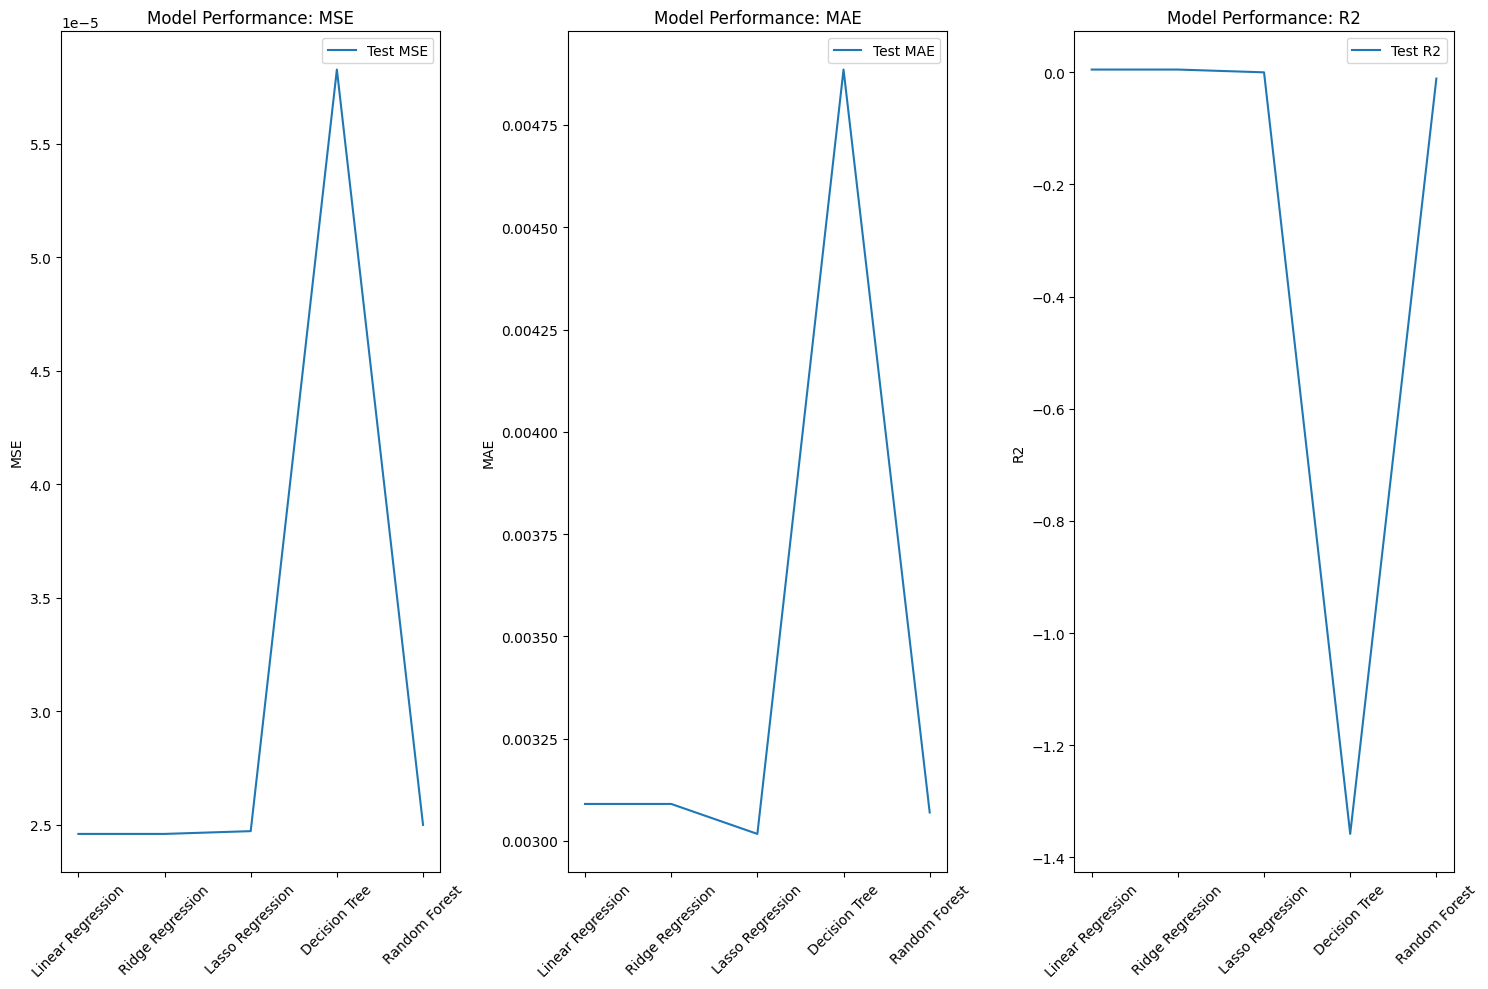

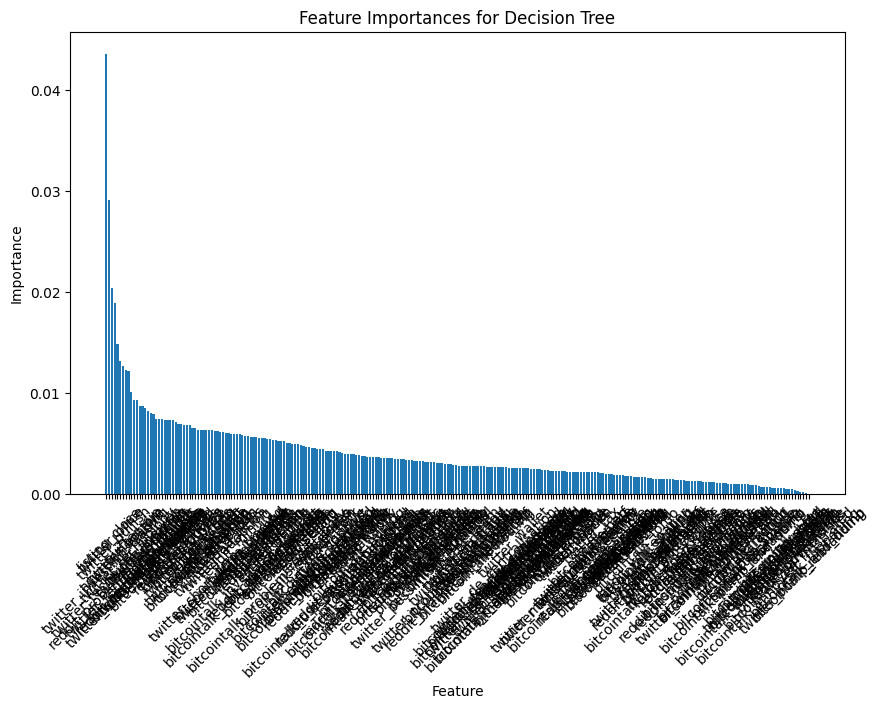

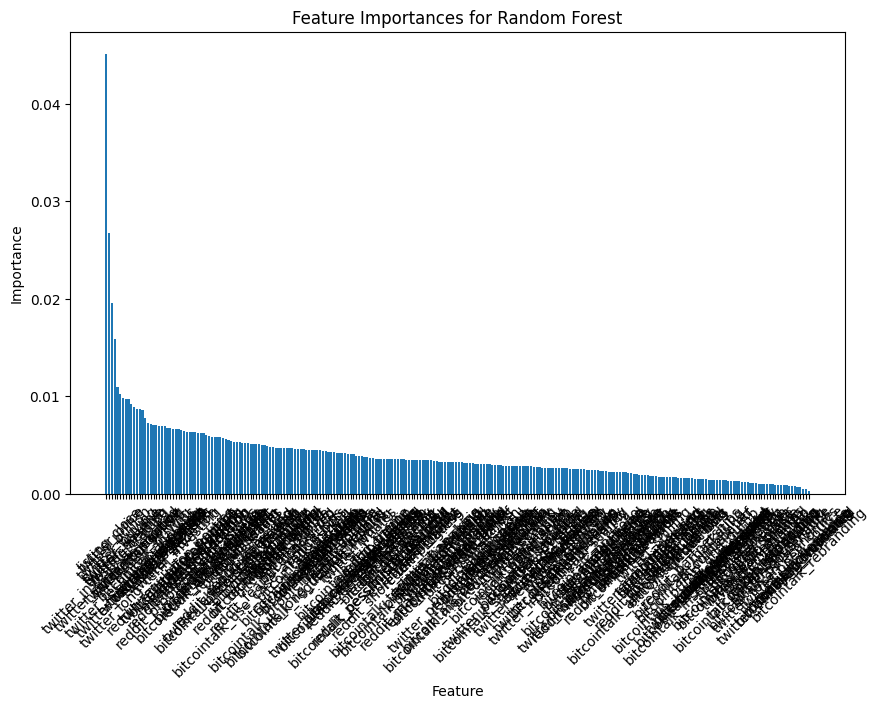

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from datetime import datetime
from typing import Tuple
from sklearn.impute import SimpleImputer

# Load your data
# Replace with your actual data loading mechanism
df = pd.read_excel('/content/augmento_btc_returns.xls')

# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor()
}

def custom_train_test_split(df: pd.DataFrame, cutoff_date: datetime, target_column_name: str, date_column_name: str) -> Tuple[pd.DataFrame, pd.Series, pd.DataFrame, pd.Series]:
    """
    Splits a DataFrame into training and testing sets based on a specified cutoff date.

    Parameters:
    - df (pd.DataFrame): The complete dataset containing both features and the target variable.
    - cutoff_date (datetime): The date used to split the data. Data up to this date are included
      in the training set, while data from this date onwards are in the testing set.
    - target_column_name (str): The name of the target variable column in the dataset.
    - date_column_name (str): The name of the column containing the dates.

    Returns:
    - Tuple[pd.DataFrame, pd.Series, pd.DataFrame, pd.Series]: A tuple containing four elements:
      X_train (DataFrame), y_train (Series), X_test (DataFrame), and y_test (Series).
      X_train and X_test contain the features, while y_train and y_test contain the target variable.
    """
    # Convert the date column to datetime objects
    df[date_column_name] = pd.to_datetime(df[date_column_name])

    # Split the data based on the cutoff date
    train_data = df[df[date_column_name] < cutoff_date].reset_index(drop=True)
    test_data = df[df[date_column_name] >= cutoff_date].reset_index(drop=True)

    # Extract features and target variable for training and testing sets
    X_train = train_data.drop(columns=[target_column_name, date_column_name])  # Remove target and date columns
    y_train = train_data[target_column_name]
    X_test = test_data.drop(columns=[target_column_name, date_column_name])  # Remove target and date columns
    y_test = test_data[target_column_name]

    return X_train, y_train, X_test, y_test

# Define the cutoff date for splitting data
cutoff_date = datetime(2023, 1, 1)

# Assuming 'date' is the name of your date column and 'returns' is your target column
date_column_name = 'date'
target_column_name = 'returns'

# Split the data
X_train, y_train, X_test, y_test = custom_train_test_split(
    df=df,
    cutoff_date=cutoff_date,
    target_column_name=target_column_name,
    date_column_name=date_column_name
)

# Check for NaN values in y_train
if y_train.isnull().any():
    # Handle NaN values in y_train (for example, drop NaN rows)
    X_train = X_train[~y_train.isnull()]
    y_train = y_train.dropna()

# Check for NaN values in y_test
if y_test.isnull().any():
    # Handle NaN values in y_test (for example, drop NaN rows)
    X_test = X_test[~y_test.isnull()]
    y_test = y_test.dropna()

# Define a pipeline with imputation and scaling
pipeline = make_pipeline(
    SimpleImputer(strategy='mean'),  # Impute missing values with mean
    StandardScaler()                # Scale the data
)

# Fit and transform the pipeline on training data
X_train_scaled = pipeline.fit_transform(X_train)
# Transform the test data using the fitted pipeline
X_test_scaled = pipeline.transform(X_test)

# Evaluate models
results = []
feature_importances = {}

# Loop through each model, train it, evaluate, and collect results
for name, model in models.items():
    model.fit(X_train_scaled, y_train)  # Train the model

    # Evaluate the model on the test data
    test_predictions = model.predict(X_test_scaled)
    test_mse = mean_squared_error(y_test, test_predictions)
    test_mae = mean_absolute_error(y_test, test_predictions)
    test_r2 = r2_score(y_test, test_predictions)

    # Store the performance metrics for each model
    results.append({'Model': name, 'Test MSE': test_mse, 'Test MAE': test_mae, 'Test R2': test_r2})

    # If the model has feature importances, store them for later use
    if hasattr(model, 'feature_importances_'):
        feature_importances[name] = model.feature_importances_

# Convert the results list into a DataFrame for easier viewing
results_df = pd.DataFrame(results)
print(results_df)

# Plotting performance metrics for each model
metrics = ['MSE', 'MAE', 'R2']
plt.figure(figsize=(15, 10))

for i, metric in enumerate(metrics):
    # Create a subplot for each metric
    plt.subplot(1, 3, i+1)
    plt.plot(results_df['Model'], results_df[f'Test {metric}'], label=f'Test {metric}')
    plt.title(f'Model Performance: {metric}')
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    plt.legend()

plt.tight_layout()
plt.show()

# Plotting feature importances for each model (if available)
for model_name, importances in feature_importances.items():
    # Sort the feature importances in descending order
    indices = np.argsort(importances)[::-1]
    sorted_names = X_train.columns[indices]  # Use X_train columns for feature names

    # Create a bar plot for each model's feature importances
    plt.figure(figsize=(10, 6))
    plt.title(f'Feature Importances for {model_name}')
    plt.bar(range(len(importances)), importances[indices], align='center')
    plt.xticks(range(len(importances)), sorted_names, rotation=45)
    plt.ylabel('Importance')
    plt.xlabel('Feature')
    plt.show()


In [ ]:
# Plotting feature importances for each model (if available)
for model_name, importances in feature_importances.items():
  # Sort features by importance in descending order
  indices = np.argsort(importances)[::-1]
  sorted_names = [features[i] for i in indices]

  # Truncate to top 10 features
  top_10_features = sorted_names[:10]
  top_10_importances = importances[indices][:10]

  plt.figure(figsize=(10, 6))
  plt.title(f'Top 10 Feature Importances for {model_name}')
  plt.bar(range(len(top_10_importances)), top_10_importances, align='center')
  plt.xticks(range(len(top_10_importances)), top_10_features, rotation=45)
  plt.ylabel('Importance')
  plt.xlabel('Feature')
  plt.show()

Experiment 3 - Split the training and testing across years, with Normalization

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from datetime import datetime
from typing import Tuple

# Assuming df, features, and target are defined
# df = ... (Your DataFrame)
# features = ... (List of feature column names, excluding the 'Date' column)
# target = ... (Target column name)
column_names = df.columns

# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor()
}

def custom_train_test_split(df: pd.DataFrame, cutoff_date: datetime, target_column_name: str) -> Tuple[pd.DataFrame, pd.Series, pd.DataFrame, pd.Series]:
    """
    Splits a DataFrame into training and testing sets based on a specified cutoff date.

    This function is designed to segment a dataset for time-series analysis, where the integrity
    of the temporal order is crucial. Data points before the cutoff date are used for training,
    while those on or after this date are reserved for testing. This method ensures that the
    testing data simulates a future period relative to the training data.

    Parameters:
    - df (pd.DataFrame): The complete dataset containing both features and the target variable.
    - cutoff_date (datetime): The date used to split the data. Data up to this date are included
      in the training set, while data from this date onwards are in the testing set.
    - target_column_name (str): The name of the target variable column in the dataset.

    Returns:
    - Tuple[pd.DataFrame, pd.Series, pd.DataFrame, pd.Series]: A tuple containing four elements:
      X_train (DataFrame), y_train (Series), X_test (DataFrame), and y_test (Series).
      X_train and X_test contain the features, while y_train and y_test contain the target variable.
    """

    df['Date'] = pd.to_datetime(df['Date'])
    train_data = df[df['Date'] < cutoff_date].reset_index(drop=True)
    test_data = df[df['Date'] >= cutoff_date].reset_index(drop=True)

    X_train = train_data[features]  # Ensure 'Date' is not in 'features'
    y_train = train_data[target_column_name]
    X_test = test_data[features]  # Ensure 'Date' is not in 'features'
    y_test = test_data[target_column_name]

    return X_train, y_train, X_test, y_test

# Define the cutoff date for splitting data
cutoff_date = datetime(2023, 1, 1)

# Split the data
X_train, y_train, X_test, y_test = custom_train_test_split(
    df=df,
    cutoff_date=cutoff_date,
    target_column_name=target
)

# Apply normalization
normalizer = MinMaxScaler()
X_train_normalized = normalizer.fit_transform(X_train)
X_test_normalized = normalizer.transform(X_test)

results = []
feature_importances = {}

# Loop through each model, train it, evaluate, and collect results
for name, model in models.items():
    # Train the model on the training data
    model.fit(X_train_scaled, y_train)

    # Evaluate the model on the test data
    test_predictions = model.predict(X_test_scaled)
    test_mse = mean_squared_error(y_test, test_predictions)
    test_mae = mean_absolute_error(y_test, test_predictions)
    test_r2 = r2_score(y_test, test_predictions)

    # Store the performance metrics for each model
    results.append({'Model': name, 'Test MSE': test_mse, 'Test MAE': test_mae, 'Test R2': test_r2})

    # If the model has feature importances, store them for later use
    if hasattr(model, 'feature_importances_'):
        feature_importances[name] = model.feature_importances_

# Convert the results list into a DataFrame for easier viewing
results_df = pd.DataFrame(results)
print(results_df)

# Plotting performance metrics for each model
metrics = ['MSE', 'MAE', 'R2']
plt.figure(figsize=(15, 10))

for i, metric in enumerate(metrics):
    # Create a subplot for each metric
    plt.subplot(1, 3, i+1)
    plt.plot(results_df['Model'], results_df[f'Test {metric}'], label=f'Test {metric}')
    plt.title(f'Model Performance: {metric}')
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    plt.legend()

plt.tight_layout()
plt.show()

# Plotting feature importances for each model (if available)
for model_name, importances in feature_importances.items():
    # Sort the feature importances in descending order
    indices = np.argsort(importances)[::-1]
    sorted_names = [column_names[i] for i in indices]

    # Create a bar plot for each model's feature importances
    plt.figure(figsize=(10, 6))
    plt.title(f'Feature Importances for {model_name}')
    plt.bar(range(len(importances)), importances[indices], align='center')
    plt.xticks(range(len(importances)), sorted_names, rotation=45)
    plt.ylabel('Importance')
    plt.xlabel('Feature')
    plt.show()

Experiment 4 - Split the training and testing across years, with Normalization, then run a LSTM RNN based on this architecture.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from datetime import datetime
from typing import Tuple

def custom_train_test_split(df: pd.DataFrame, cutoff_date: datetime, target_column_name: str) -> Tuple[pd.DataFrame, pd.Series, pd.DataFrame, pd.Series]:
    """
    Splits a DataFrame into training and testing sets based on a specified cutoff date.

    This function is designed to segment a dataset for time-series analysis, where the integrity
    of the temporal order is crucial. Data points before the cutoff date are used for training,
    while those on or after this date are reserved for testing. This method ensures that the
    testing data simulates a future period relative to the training data.

    Parameters:
    - df (pd.DataFrame): The complete dataset containing both features and the target variable.
    - cutoff_date (datetime): The date used to split the data. Data up to this date are included
      in the training set, while data from this date onwards are in the testing set.
    - target_column_name (str): The name of the target variable column in the dataset.

    Returns:
    - Tuple[pd.DataFrame, pd.Series, pd.DataFrame, pd.Series]: A tuple containing four elements:
      X_train (DataFrame), y_train (Series), X_test (DataFrame), and y_test (Series).
      X_train and X_test contain the features, while y_train and y_test contain the target variable.
    """

    df['Date'] = pd.to_datetime(df['Date'])
    train_data = df[df['Date'] < cutoff_date].reset_index(drop=True)
    test_data = df[df['Date'] >= cutoff_date].reset_index(drop=True)

    X_train = train_data[features]
    y_train = train_data[target_column_name]
    X_test = test_data[features]
    y_test = test_data[target_column_name]

    return X_train, y_train, X_test, y_test

def create_sequences(X, y, time_steps):
  """
    Converts time series data into a format suitable for training RNN models.

    This function creates sequences from the provided feature data (X) and the corresponding
    targets (y), with each sequence having a specified length (time_steps). The function
    iterates through the dataset, creating overlapping sequences of the input features and
    their corresponding next value as the target.

    Parameters:
    - X (array-like): Feature data for the time series. Typically a 2D array where each row
      represents a time point and each column a feature.
    - y (array-like): Target data for the time series. Usually a 1D array where each element
      corresponds to a time point.
    - time_steps (int): The number of time steps to include in each sequence, determining
      the sequence length.

    Returns:
    - Tuple[np.ndarray, np.ndarray]: Two numpy arrays, the first containing the sequences
      of features and the second containing the corresponding target values. Each sequence
      in the first array is paired with a single target value in the second array.
    """

  Xs, ys = [], []
  for i in range(len(X) - time_steps):
    Xs.append(X[i:(i + time_steps)])
    ys.append(y[i + time_steps])
  return np.array(Xs), np.array(ys)

# Example usage with the LSTM model
time_steps = 30  # This defines the sequence length

# Create sequences from the training and test data
#X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train.values, time_steps)
#X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test.values, time_steps)

# Define the cutoff date for splitting data
cutoff_date = datetime(2023, 1, 1)

# Split the data
X_train, y_train, X_test, y_test = custom_train_test_split(
    df=df,
    cutoff_date=cutoff_date,
    target_column_name=target
)

# Normalize the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create sequences for LSTM
# You need to implement create_sequences function based on your data
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, time_steps=30)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, time_steps=30)

# Define the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

# Compile and train the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train_seq, y_train_seq, epochs=100, batch_size=32, validation_split=0.1)

# Evaluate the model
test_predictions = model.predict(X_test_seq)
test_mse = mean_squared_error(y_test_seq, test_predictions)
print("Test MSE:", test_mse)